In [1]:
from obspy.core import Stream, read
from obspy.geodetics import gps2dist_azimuth, kilometer2degrees
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl 
from matplotlib.colors import Normalize
import pandas as pd
import os 
import os.path

In [2]:
path = '/Users/sydneydybing/StrainProject/2024/tohoku_strain_data/'

eq_name = 'tohoku'
eq_ot = '2011-03-11T05:46:24.120Z'
eq_lon = 142.373
eq_lat = 38.297

In [3]:
# Calculate hypocentral distances and add to dataframe

stas = pd.read_csv(path + 'stations.list', delimiter = '\s+')

hypdists = []

for i in range(len(stas)):
    
    sta = stas['Station_name'][i]
    print(sta)
    
    sta_lat = float(stas['latitude'][i])
    sta_lon = float(stas['longitude'][i])

    distaz = gps2dist_azimuth(eq_lat, eq_lon, sta_lat, sta_lon)
    dist_m = distaz[0]
    dist_km = dist_m/1000
    
    print(dist_km)
    
    hypdists.append(dist_km)
    
stas['hyp_dist_km'] = hypdists
stas.to_csv(path + 'stations_hypdists.list', index = False)

KST1
792.7467649848624
HGM1
773.8096436824068
ICU1
743.4918293792737
ANO1
661.2511848218634
SSK1
981.5462440252589
UWA1
1045.6834534542518
MUR1
927.2008269606409
MYM1
724.6942372625917


In [4]:
dist_array = pd.read_csv(path + 'stations_hypdists.list')
dist_array

,Station_name,latitude,longitude,azimuth(S1),azimuth(S2),azimuth(S3),azimuth(S4),hyp_dist_km
0,KST1,33.5201,135.8363,310,40,85,175,792.746765
1,HGM1,33.8675,135.7318,337,67,112,202,773.809644
2,ICU1,33.9001,136.1379,141,231,276,6,743.491829
3,ANO1,34.7870,136.4019,38,128,173,263,661.251185
4,SSK1,33.3896,133.3229,355,85,130,220,981.546244
5,UWA1,33.3859,132.4823,222,312,357,87,1045.683453
6,MUR1,33.2856,134.1563,147,237,282,12,927.200827
7,MYM1,34.1123,136.1815,237,327,12,102,724.694237


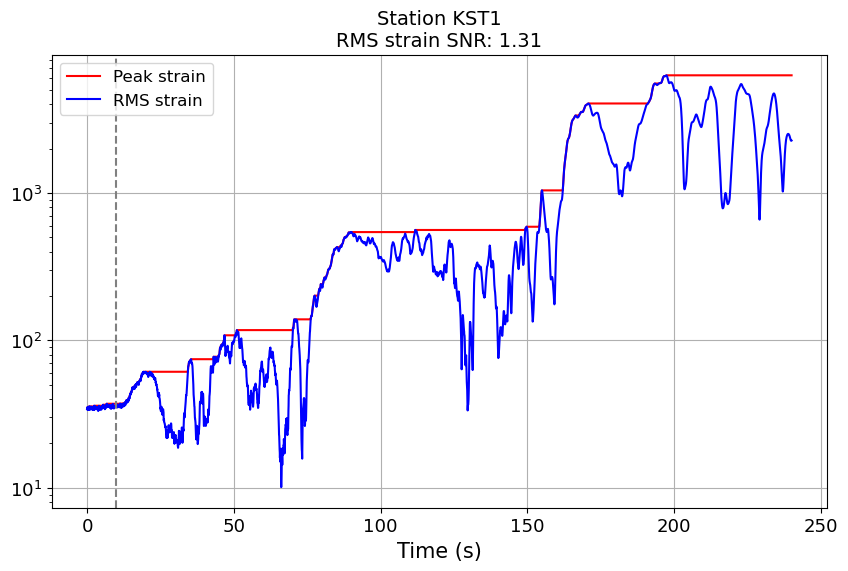

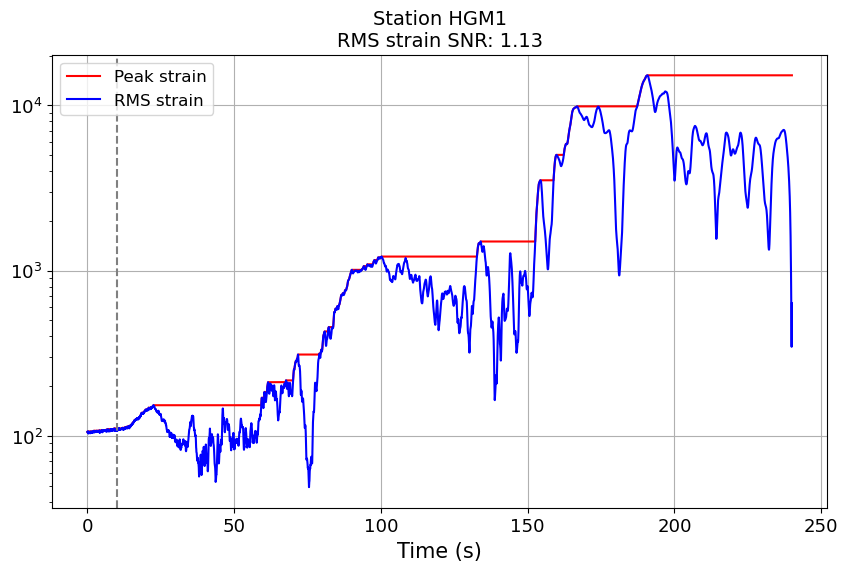

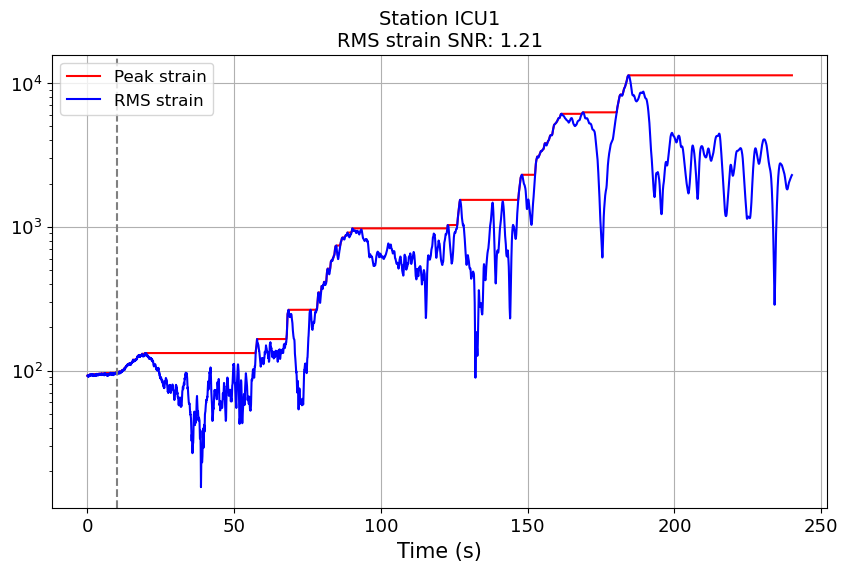

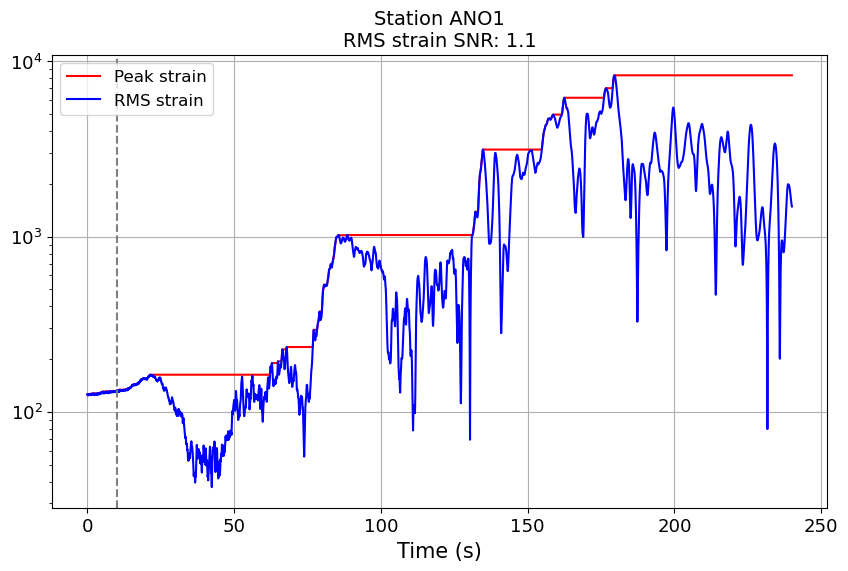

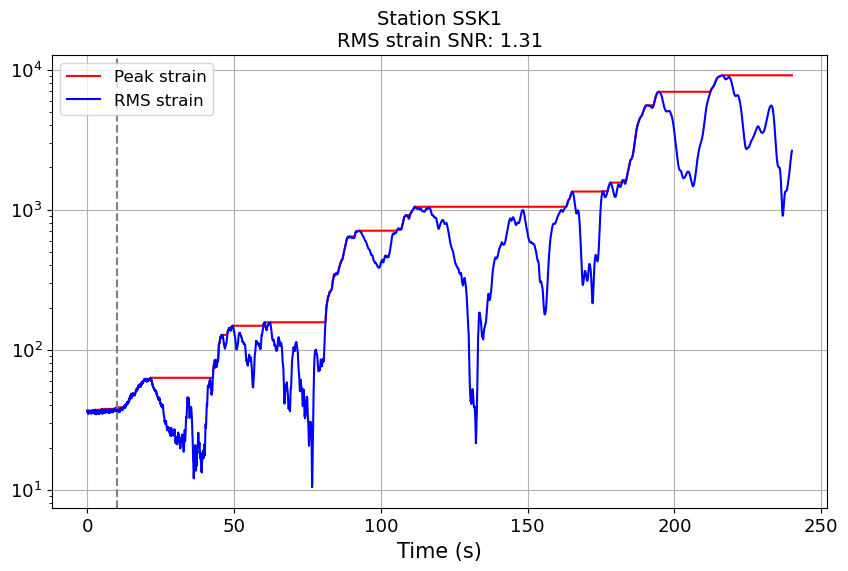

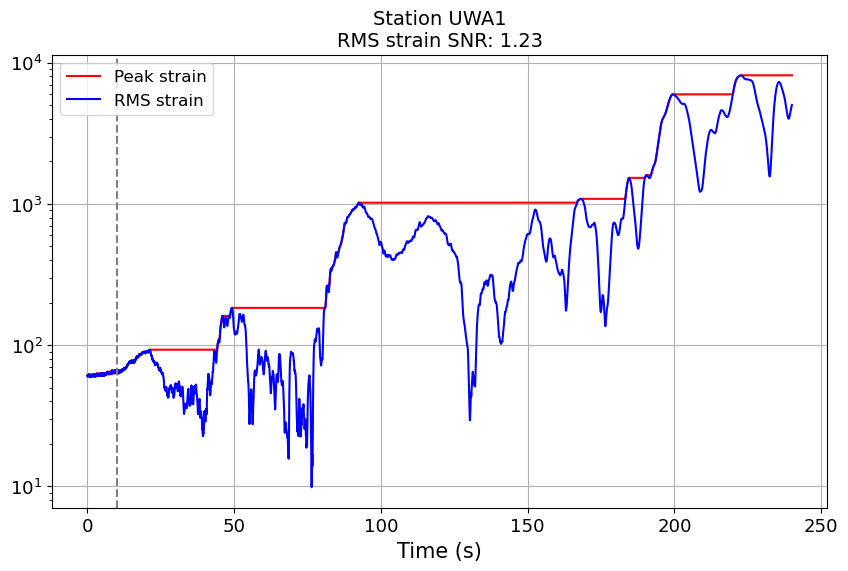

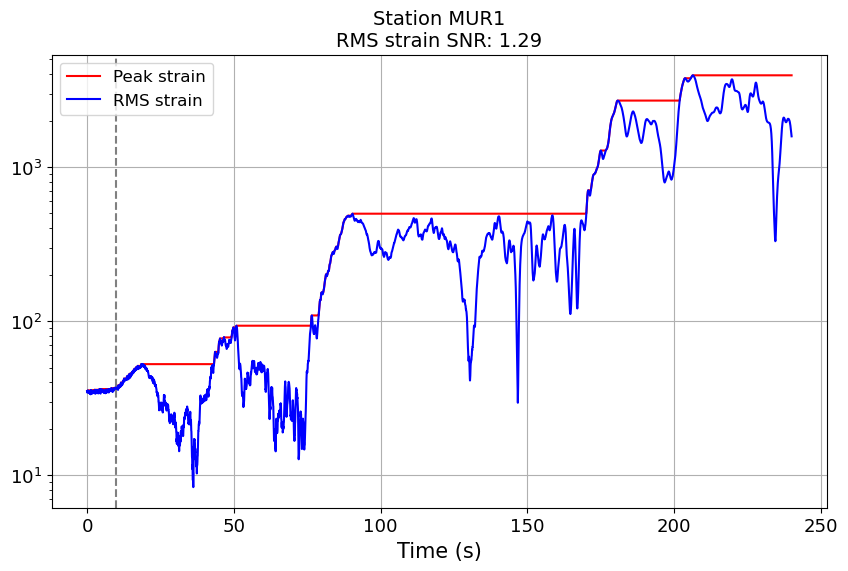

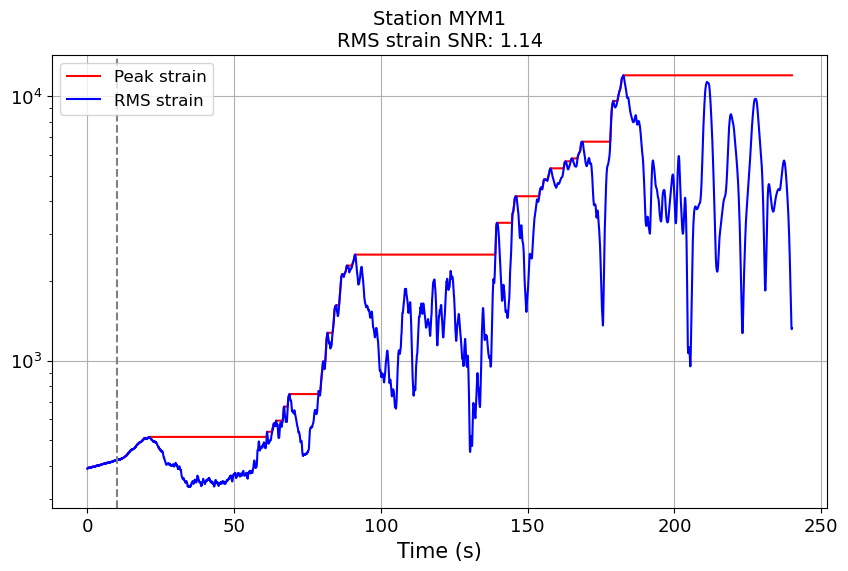

In [5]:
rms_snrs = []

for i in range(len(dist_array)):
    
    sta = dist_array['Station_name'][i]
    hypdist = float(dist_array['hyp_dist_km'][i])
    
#     print(eq_id, sta)
    
    strain_waves = read(path + '3comp_trimmed_rms/' + str(sta) + '.mseed') # RMS waveforms
    
    times = strain_waves[0].times()
    samples = np.arange(strain_waves[0].stats.npts)
    data = strain_waves[0].data
    
    samp_rate = strain_waves[0].stats.sampling_rate
    
    samples_to_p_pick = 10 * samp_rate
    
    noise_start = int(samples_to_p_pick - 9*samp_rate) # 8 seconds of noise
    noise_end = int(samples_to_p_pick - 1*samp_rate)

    signal_start = int(samples_to_p_pick)
    signal_end = int(samples_to_p_pick + 10*samp_rate) # 30 seconds of signal
    
    signal = data[signal_start:signal_end]
    noise = data[noise_start:noise_end]
    
    noise_rms = np.sqrt(np.mean(noise**2))
    signal_rms = np.sqrt(np.mean(signal**2))
    snr = signal_rms/noise_rms
#     snr_db = 20*np.log10(snr)
    
    rms_snrs.append(snr)
    
#     print(snr_db)
    
    pst = read(path + '3comp_peak/' + str(sta) + '.mseed')
    # seis_waves = read(path + 'seismic_data/trimmed/' + str(eq_id) + '/' + str(sta) + '.mseed')
    
    # Plot all 3 waveforms
    
    fig = plt.figure(figsize = (10,6), dpi = 100, facecolor = 'white', num = 1, clear = True)
    ax = fig.add_subplot(111)
    ax.grid()
    ax.set_title('Station ' + str(sta) + '\nRMS strain SNR: ' + str(round(snr,2)), fontsize = 14)
    ax.plot(pst[0].times(), pst[0].data*10**9, color = 'red', label = 'Peak strain')
    ax.plot(times, data*10**9, color = 'blue', label = 'RMS strain')
    # ax2 = ax.twinx()
    # ax2.plot(seis_waves[0].times(), seis_waves[0].data, color = 'green', alpha = 0.5, label = 'Seismic data')
    ax.set_yscale('log')
#     ax.set_ylabel('Log of peak extensional\nmicrostrain ($10^{-6}$)', fontsize = 15)
    ax.set_xlabel('Time (s)', fontsize = 15)
    # ax.set_xlim(0,40)
#     ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
    ax.axvline(x = 10, color = 'gray', linestyle = '--')
    ax.tick_params(labelsize = 13)
    ax.legend(loc = 'upper left', fontsize = 12)
    # ax2.legend(loc = 'lower right', fontsize = 12)
    
    plt.show()
    
#     # Create folder for the event
#     eq_sta_save_dir = path_to_files + 'figures/filtered_rms_peak_seismic_overlay_plots/' + str(eq_id) + '/'
# #     print(eq_sta_save_dir)
#     if os.path.isdir(eq_sta_save_dir):
#         pass
#     else:
#         os.makedirs(eq_sta_save_dir)
    
#     plt.savefig(eq_sta_save_dir + str(sta) + '.png', format = 'PNG')
#     plt.close();
    
stas['rms_snr'] = rms_snrs
stas.to_csv(path + '3comp_stations_hypdists_snrs.list', index = False)

In [6]:
snr_array = pd.read_csv(path + '3comp_stations_hypdists_snrs.list')
snr_array

,Station_name,latitude,longitude,azimuth(S1),azimuth(S2),azimuth(S3),azimuth(S4),hyp_dist_km,rms_snr
0,KST1,33.5201,135.8363,310,40,85,175,792.746765,1.310234
1,HGM1,33.8675,135.7318,337,67,112,202,773.809644,1.130788
2,ICU1,33.9001,136.1379,141,231,276,6,743.491829,1.212499
3,ANO1,34.7870,136.4019,38,128,173,263,661.251185,1.100349
4,SSK1,33.3896,133.3229,355,85,130,220,981.546244,1.311658
5,UWA1,33.3859,132.4823,222,312,357,87,1045.683453,1.231449
6,MUR1,33.2856,134.1563,147,237,282,12,927.200827,1.287158
7,MYM1,34.1123,136.1815,237,327,12,102,724.694237,1.136677
